In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import (
    BatchNormalization,
    Activation,
    Conv2DTranspose,
    Conv2D,
    LeakyReLU,
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

# Load the MNIST data
We want to generate numbers and we dont care which number. Therefor we olny want the training images

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64)

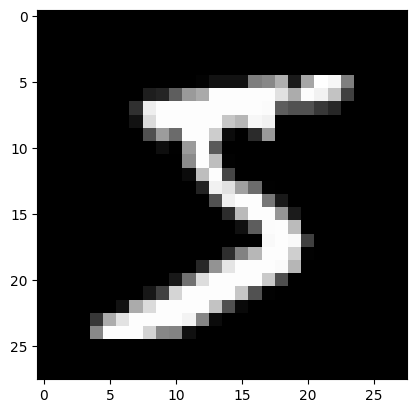

In [5]:
for batch in train_dataset:
    plt.imshow(batch[0], cmap="gray")
    break

# Generator model

In [6]:
def build_generator(noise_dim):
    model = Sequential()

    model.add(Dense(64 * 7 * 7, activation="relu", input_dim=noise_dim))
    model.add(Reshape((7, 7, 64)))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2D(1, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))

    return model

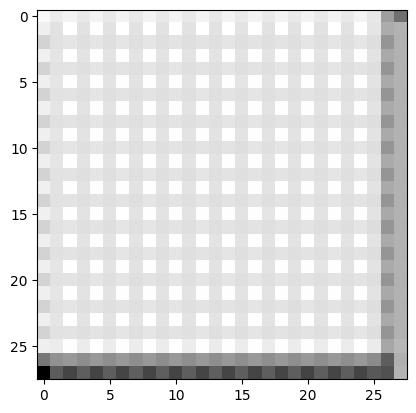

In [7]:
generator = build_generator(20)

noise = tf.random.normal([1, 20])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap="gray")

In [8]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Dicriminator model

In [9]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=image_shape)
    )
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model

In [10]:
discriminator = build_discriminator((28, 28, 1))
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.49829924]], shape=(1, 1), dtype=float32)


# Loss functions and optimizers

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
# We create the labels in the loss function.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    # We want the dicriminator to think all fake images are correct.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the models

In [15]:
@tf.function
def train_step(images, noise_dim):
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Set batchsize and number of generated exampels to the same number
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

In [16]:
def show_generated_image(generator, noise_dim):
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate an image from the noise
    generated_image = generator.predict(noise)[0]

    # Plot the generated image
    plt.imshow(generated_image, cmap="gray")
    plt.axis("off")
    plt.show()

In [17]:
def train(dataset, epochs, noise_dim):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, noise_dim)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

        # Show generated image
        show_generated_image(generator, noise_dim)

c:\Users\jonas\Documents\GitHub\DEEP ML\deep-ml\deepml\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 40.981372356414795 sec
1/1 [==============================] - 0s 173ms/step


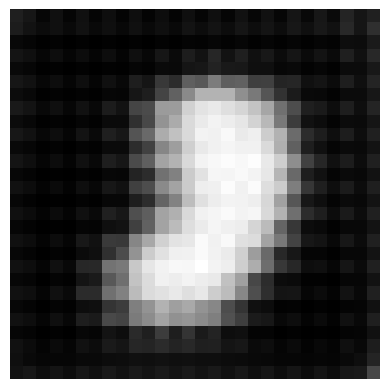

Time for epoch 2 is 36.154913902282715 sec
1/1 [==============================] - 0s 37ms/step


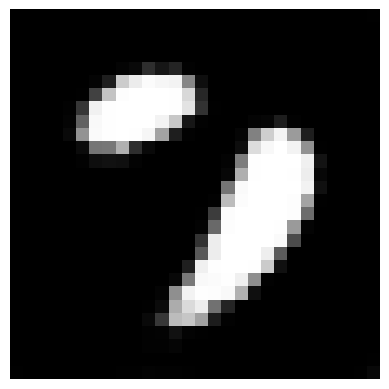

Time for epoch 3 is 36.3927800655365 sec
1/1 [==============================] - 0s 27ms/step


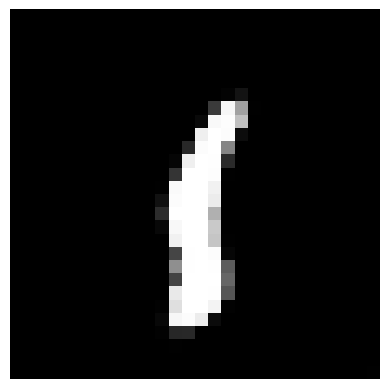

Time for epoch 4 is 36.26990795135498 sec
1/1 [==============================] - 0s 26ms/step


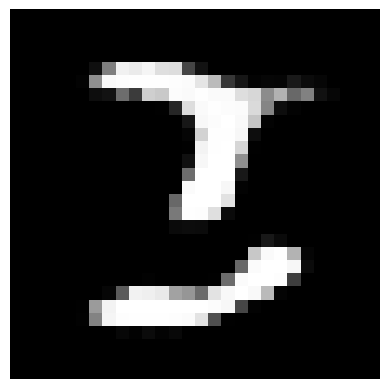

Time for epoch 5 is 36.79761505126953 sec
1/1 [==============================] - 0s 30ms/step


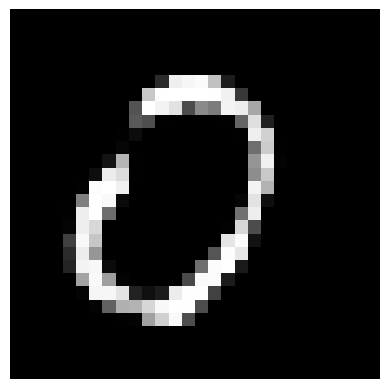

Time for epoch 6 is 36.99548411369324 sec
1/1 [==============================] - 0s 26ms/step


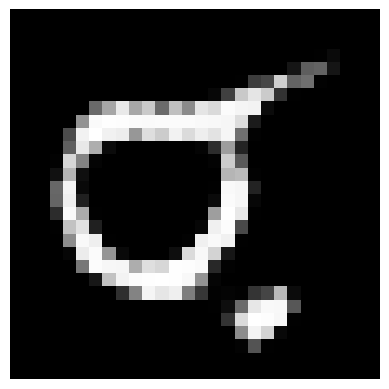

Time for epoch 7 is 37.22030687332153 sec
1/1 [==============================] - 0s 28ms/step


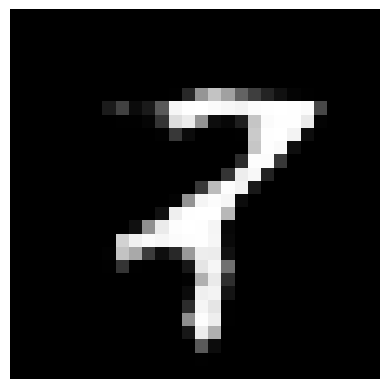

Time for epoch 8 is 36.565714836120605 sec
1/1 [==============================] - 0s 30ms/step


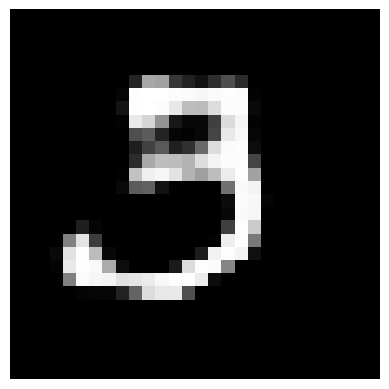

KeyboardInterrupt: 

In [18]:
train(train_dataset, 50, 20)

# Tasks
Change the model architectures and try to generate as good images as possible.

Remember to not only change the generator. If the discriminator gets better, the generator need to generate better images.

Ifall modellen blir bra, testa att plotta ut flera siffror 